In [1]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load functions for data analysis
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf    
import pandas, os, scipy
import seaborn as sns
from scipy import stats
import numpy as np
pandas.options.mode.chained_assignment = None
import pickle 

In [3]:
# scr data anslysis functions
sys.path.append(os.getcwd() + '/scr/')
from adapting_fyp_analysis import experimental

In [4]:
scr_data_path = os.getcwd() + '/scr/data_study_two/'
behavioral_data = os.getcwd() + '/scr/behavioral_analysis_objects.pkl'
gaze_analysis_data = os.getcwd() + '/scr/gaze_analysis_objects.pkl'
results_folder = 'results/figures'

In [5]:
day_one = experimental(scr_data_path)
day_one.day = 1
day_one.preprocessData()

In [6]:
day_two = experimental(scr_data_path)
day_two.day = 2
day_two.preprocessData()

In [7]:
def counterbalance_info(day_two): 
    
    plus_first, minus_first = [], []
    
    for i_subject in range(0,len(day_two.subjectNames)): 

        subject_number = int(day_two.subjectNames[i_subject][1:3])

        condMarkers = np.copy(day_two.transData[i_subject][1])
        neg_ons = day_two.stimuli(condMarkers[:,1])[0]
        pos_ons = day_two.stimuli(condMarkers[:,0])[0]

        if pos_ons[0] > neg_ons[0]: 
            plus_first.append(i_subject)
        else: 
            minus_first.append(i_subject)

    cb = np.array(minus_first)
    bc = np.array(plus_first)
    
    order = np.zeros(day_two.nSubjects)
    order[minus_first] = 1
    
    _dict_ = {'counter_balanced_inds': cb, 
          'not_counter_balanced_inds': bc, 
          'order': order} 

    return _dict_
    

In [8]:
def log_transform(_a_): 
    """convenience function"""
    return np.log(1 + _a_)

In [9]:
def extract_conditioning_data(scr_data_, type_ , location_, dict_=''):
    '''
    scr_data_ is either day_one or day_two
    type_ is either 'raw' or 'trans'
    location_ is either 'onset' (predictive) or 'offset' (contagion)
    '''
    
    if not dict_: dict_ = {}
    
    dict_['%s_%s'%(type_, location_)] = {} 
    
    if location_ == 'onset':
        start_ind, end_ind = 4, 13 
        trial_ = list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
        negative_ = np.zeros([scr_data_.nSubjects,len(range(start_ind,end_ind))])
    else: 
        trial_ = np.array([3, 5, 6, 8, 9, 11])# list(range(start_ind, end_ind))
        positive_ = np.zeros([scr_data_.nSubjects,len(trial_)])
        negative_ = np.zeros([scr_data_.nSubjects,len(trial_)])
    
    for i_stim in range(0,len(trial_)):
        positive_[:,i_stim], negative_[:,i_stim] = scr_data_.amplitudeDifference(type_, trial_[i_stim], location_);

    significance_ = np.zeros(scr_data_.nSubjects)
    for iSubject in range(0,scr_data_.nSubjects): 
        significance_[iSubject] = scipy.stats.ttest_ind(positive_[iSubject,:], negative_[iSubject,:])[1];
        
    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(positive_)
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(negative_)
    dict_['%s_%s'%(type_, location_)]['significe_difference'] = significance_
    dict_['%s_%s'%(type_, location_)]['learning'] = mean(log_transform(positive_) - log_transform(negative_),1)
    
    return dict_

In [10]:
def extract_renewal_data(day_two, type_, location_, dict_=''): 
        
    if not dict_: dict_ = {} 
    dict_['%s_%s'%(type_, location_)] = {} 
    
    # order of outputs here is switched because of changes in experimental outputs
    minus, plus = day_two.amplitudeDifference(type_, 0, location_);
    
    dict_['%s_%s'%(type_, location_)]['contrast'] = log_transform(plus) - log_transform(minus) 
    dict_['%s_%s'%(type_, location_)]['positive_stim'] = log_transform(plus) 
    dict_['%s_%s'%(type_, location_)]['negative_stim'] = log_transform(minus)
    
    return dict_


In [11]:

def test_single_relationship(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[0,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)

def control_for_order(_df_, _predictor_, loud=1): 

    formula = 'renewal ~ C(order) + %s'%_predictor_
    model = ols(formula, _df_).fit()
    aov_table = anova_lm(model, typ=2)
    p_val = aov_table.values[1,3]
    
    if loud: print '\n\t\t', formula, '\n\n', aov_table, '\n'
    
    return float('%.4f'%p_val)
    
    

In [12]:
def show_order_effects(): 
    
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(order))/100
    scatter(order + jitter,log_renewal, alpha=.8, s=90)
    scatter(order + jitter,log_renewal, color='darkcyan', alpha=.1, s=300)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    xlim(-.2, 1.2)
    ylim(-2.5, 3)
    title('Main Effect of order on SCR to CS on day two (p < %.04f)\n'%p_val_order_effects, fontsize=15); 


In [13]:
# extract measure of predictive learning across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'onset')
# extract measure of emotional contagion across conditioning
conditioning = extract_conditioning_data(day_one, 'trans', 'offset', conditioning)
# extract measure for determining non-responders
conditioning = extract_conditioning_data(day_one, 'raw', 'onset', conditioning)

In [14]:
# renewal measure -- main dependent variable of the experiment 
renewal = extract_renewal_data(day_two, 'trans', 'onset')
renewal = extract_renewal_data(day_two, 'raw',   'onset', renewal)

In [15]:
# extract information about the order of presentation of day two
counter_balance_info = counterbalance_info(day_two)

In [16]:
# set criteria for responders -- at least one scr responce > .1
responders = np.array(conditioning['raw_onset']['positive_stim'] > .01).mean(1) > 0

In [17]:
# reformat into a data frame
SCR = pandas.DataFrame({'renewal':renewal['trans_onset']['contrast'],
                        'order':counter_balance_info['order'],
                        'contagion':conditioning['trans_offset']['learning'],
                        'prediction': conditioning['trans_onset']['learning']})

subject_names = [int(day_two.subjectNames[i_subject][1:3]) for i_subject in np.nonzero(responders)[0]]
SCR.index = subject_names
# remove non-responders 
responders_data = SCR[responders]

In [18]:
#determine significance and display
renewal['significance'] = {} 
renewal['significance']['order'] = test_single_relationship(responders_data, 'order')


		renewal ~ order 

             sum_sq    df         F    PR(>F)
order      2.904245   1.0  7.832295  0.009356
Residual  10.011704  27.0       NaN       NaN 



In [19]:
def show_order_effects(): 
    figure(figsize=[8,6])
    sns.set_style("dark", {'axes.grid' : True})
    jitter = np.random.randn(len(counter_balance_info['order']))/100
    scatter(counter_balance_info['order'] + jitter,SCR['renewal'], color='midnightblue', alpha=.8, s=90)
    ylabel('Renewal \nCS+ minus CS-\n', rotation=90, fontsize=14)

    yticks([-.5,0,.5,],[-.5,0,.5])
    xticks([0, 1],['\nFirst CS','\nSecond CS'], fontsize=14)
    xlim(-.2, 1.2)
    ylim(-2.5, 3)
    title('\nMain Effect of order on skin conductance \nresponse to CS on day two (p < %.3f)\n'%renewal['significance']['order'], fontsize=20); 

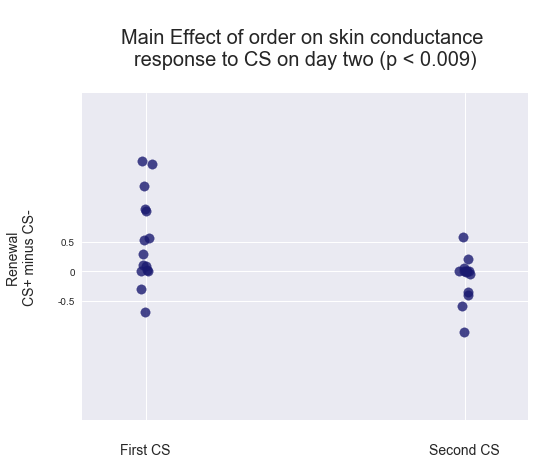

In [20]:
show_order_effects()

In [21]:
renewal['significance']['prediction']  = test_single_relationship(responders_data, 'prediction')


		renewal ~ prediction 

               sum_sq    df         F    PR(>F)
prediction   2.849876   1.0  7.644157  0.010141
Residual    10.066073  27.0       NaN       NaN 



In [22]:
renewal['significance']['contagion']   = test_single_relationship(responders_data, 'contagion')


		renewal ~ contagion 

              sum_sq    df         F    PR(>F)
contagion   0.725705   1.0  1.607353  0.215689
Residual   12.190244  27.0       NaN       NaN 



In [23]:
renewal['significance']['prediction_controlled'] = control_for_order(responders_data, 'prediction')


		renewal ~ C(order) + prediction 

              sum_sq    df         F    PR(>F)
C(order)    1.580083   1.0  4.841175  0.036873
prediction  1.525714   1.0  4.674594  0.039996
Residual    8.485990  26.0       NaN       NaN 



In [24]:
renewal['significance']['contagion_controlled']  = control_for_order(responders_data, 'contagion')


		renewal ~ C(order) + contagion 

             sum_sq    df         F    PR(>F)
C(order)   2.410865   1.0  6.409659  0.017734
contagion  0.232324   1.0  0.617671  0.439018
Residual   9.779379  26.0       NaN       NaN 



In [25]:
def show_relationships(): 
    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})
    subplot(121)
    type_color = 'xkcd:indigo'
    scatter(SCR['contagion'],SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    scatter(SCR['contagion'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['contagion'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    legend( bbox_to_anchor=(.20, 1, 1, -.1), fontsize=13)
    xlabel('Emotional contagion on day one\n CS+ minus CS- at shock offset',fontsize=13, fontweight='bold')
    ylabel('Renewal on day two\n CS+ minus CS-',fontsize=13, fontweight='bold')
    #xlim(-.4,1)
    title('Relationship between emotional contagion and renewal (p < %.1f)\n' 
          %(renewal['significance']['contagion']), fontsize=18, fontweight='bold'); 

    subplot(122)
    type_color = 'xkcd:indigo'
    scatter(SCR['prediction'], SCR['renewal'],color='xkcd:white',alpha=1,s=500, label='')
    #scatter(log_learning[responders == True], log_renewal[responders == True],color='yellow',alpha=1,s=300, label='responders')

    scatter(SCR['prediction'][counter_balance_info['order'] == False], SCR['renewal'][counter_balance_info['order']  == False],color=type_color,alpha=.8,s=150, label='CS+ first')
    scatter(SCR['prediction'][counter_balance_info['order']  == True], SCR['renewal'][counter_balance_info['order']  == True], color=type_color,alpha=.8, s=100,  label='CS- first', linewidth=3, facecolor='none')

    yticks([-.1,0,.1],[-.1,'',.1])
    xticks([-.1,0,.1],[-.1,0,.1])

    xlabel('Predictive learning on day one\n CS+ minus CS- at stimulus onset',fontsize=13, fontweight='bold')
    yticks([-.1,0,.1],['','',''])
    title('\n Relationship between predictive learning and renewal (p < %.3f)\n' 
          %(renewal['significance']['prediction']), fontsize=18, fontweight='bold'); 
    suptitle('STUDY TWO', y =1.15, fontsize=20, fontweight='bold')
    
    savefig('%s/day_two_scr_comparision.png'%results_folder)

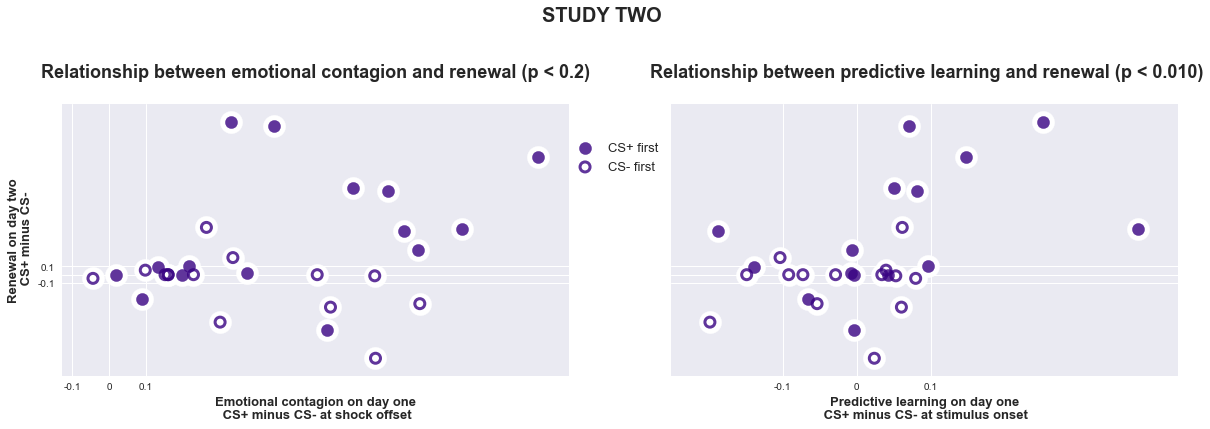

In [26]:
show_relationships()

In [27]:
def partition_analysis(_cond, _rnwl, _title, _figure_name): 
    
    cutoffs = {'1) significance':.05,
               '2) upper_quartile':np.percentile(conditioning['trans_onset']['significe_difference'], 25), 
               '3) upper third': np.percentile(conditioning['trans_onset']['significe_difference'], 33)}
    
    cutoff_keys = cutoffs.keys(); cutoff_keys.sort() 

    cond_sig_on = np.zeros(day_one.nSubjects)
    for i_subject in range(0,day_one.nSubjects): 
        cond_sig_on[i_subject] = scipy.stats.ttest_ind(_cond['positive_stim'][i_subject,:], 
                                                       _cond['negative_stim'][i_subject,:])[1];

    figure(figsize=[20,5])
    sns.set_style("dark", {'axes.grid' : True})

    for i_cutoff in range(len(cutoffs)): 

        subplot(1,3,i_cutoff + 1)
        _i_cut = cutoff_keys[i_cutoff]
        _cutoff = cutoffs[_i_cut]

        con_subs_= find(cond_sig_on < _cutoff)

        tmp_len_p = len(_rnwl['positive_stim'][con_subs_])
        tmp_len_n = len(_rnwl['negative_stim'][con_subs_])
        jitter_p = np.random.randn(tmp_len_p)/100
        jitter_n = np.random.randn(tmp_len_n)/100

        _results_ = scipy.stats.ttest_ind(_rnwl['positive_stim'][con_subs_], _rnwl['negative_stim'][con_subs_])

        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=300, alpha=1,color='white') 
        scatter(np.zeros(tmp_len_p)+ .3 + jitter_p, _rnwl['positive_stim'][con_subs_],s=100, alpha=.5,color='xkcd:red') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=300, alpha=1, color='white') 
        scatter(np.zeros(tmp_len_n)+jitter_n, _rnwl['negative_stim'][con_subs_]+ jitter_p,s=100, alpha=.5, color='midnightblue') 
        xlim([-.1,.4])
        xticks([0,.3], ['\nCS-', '\nCS+'], fontsize=15); 
        yticks([0,.5], [0.,.5], fontsize=10); 
        ylabel('Skin Conductance Response\nat first presentation of stimuli on day two')
        title('\n Subjects below %s (p < %.2f) : p < %.4f\n'%(_i_cut, _cutoff, _results_.pvalue), fontsize=15); 
    
    suptitle('Segmenting renewal scores according to how significant %s was for each subject across conditioning on day one'%(_title), 
             fontsize=15, fontweight='bold',y=1.1);
    
    savefig('%s/segmentation_analyis_%s_%s.png'%(results_folder, _title, _figure_name))
    
    return cond_sig_on

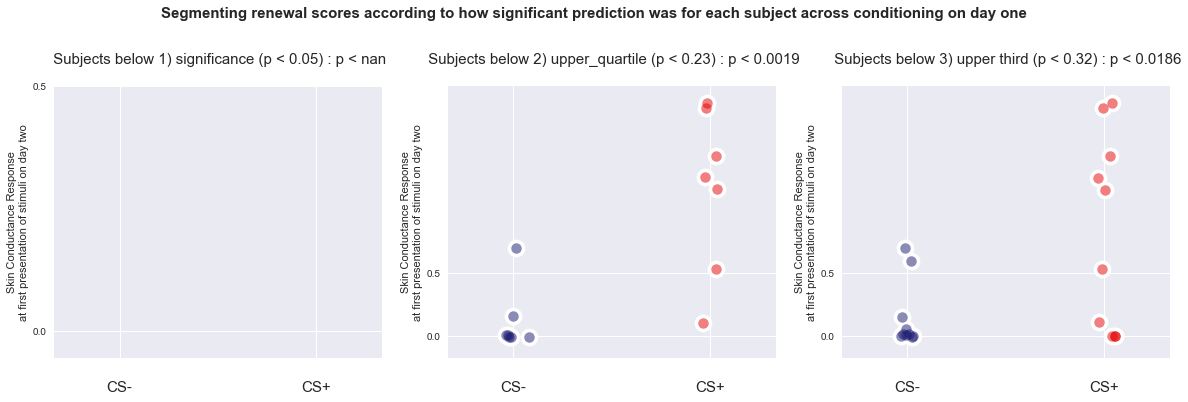

In [28]:
onset_significance = partition_analysis(conditioning['trans_onset'], renewal['trans_onset'], 'prediction', 'study_two')

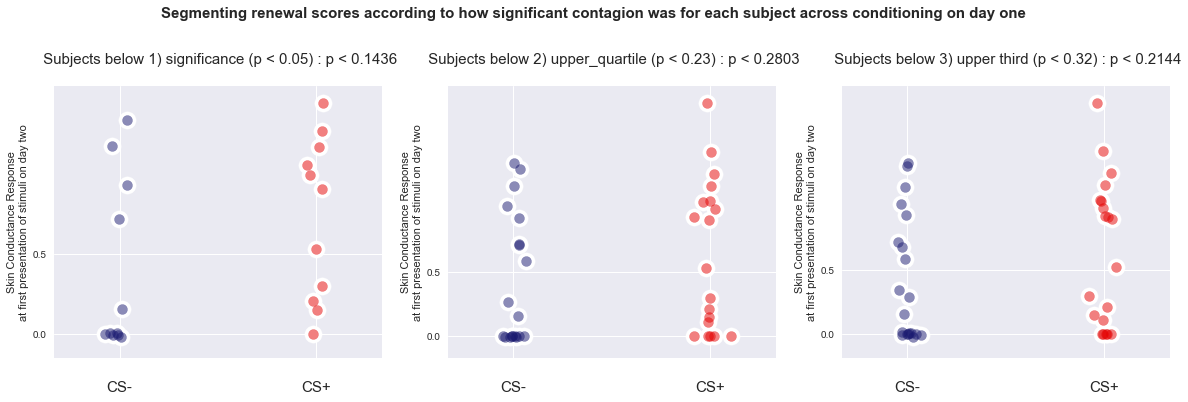

In [29]:
offset_significance = partition_analysis(conditioning['trans_offset'], renewal['trans_onset'], 'contagion', 'study_two')

In [30]:
cond_sig_on = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_on[i_subject] = scipy.stats.ttest_ind(conditioning['trans_onset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_onset']['negative_stim'][i_subject,:])[1];
    
cond_sig_off = np.zeros(day_one.nSubjects)
for i_subject in range(0,day_one.nSubjects): 
    cond_sig_off[i_subject] = scipy.stats.ttest_ind(conditioning['trans_offset']['positive_stim'][i_subject,:], 
                                                   conditioning['trans_offset']['negative_stim'][i_subject,:])[1];

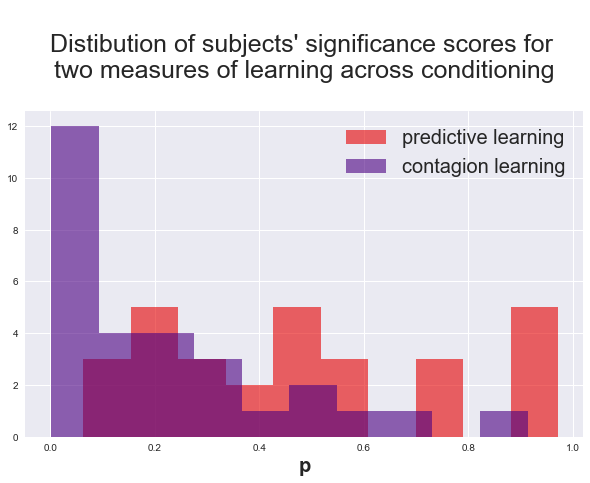

In [31]:
figure(figsize=[10,6])
hist(cond_sig_on, alpha=.6, label='predictive learning', color='xkcd:red')
hist(cond_sig_off, alpha=.6, label='contagion learning', color='indigo'); 
legend(fontsize=20)
title("\nDistibution of subjects' significance scores for \ntwo measures of learning across conditioning\n", fontsize=25); 
xlabel('p', fontweight='bold', fontsize=20); 

In [32]:
with open(gaze_analysis_data) as f:  # Python 3: open(..., 'rb')
    main, gaze_data, gaze_subjects = pickle.load(f)
    
# this is the one that I can replicate :) 
# with open('gaze/gaze_analysis_results.pkl') as f:  # Python 3: open(..., 'rb')
#     main, gaze_data, gaze_subjects = pickle.load(f)

In [33]:
print 'p < %.1e'%stats.ttest_ind( main['CS']['face'], main['CS']['wrist'], nan_policy='omit')[1] 
print 'p < %.1e'%stats.ttest_ind( main['CS']['face'], main['CS']['stim'], nan_policy='omit')[1] 

p < 8.7e-15
p < 6.3e-08


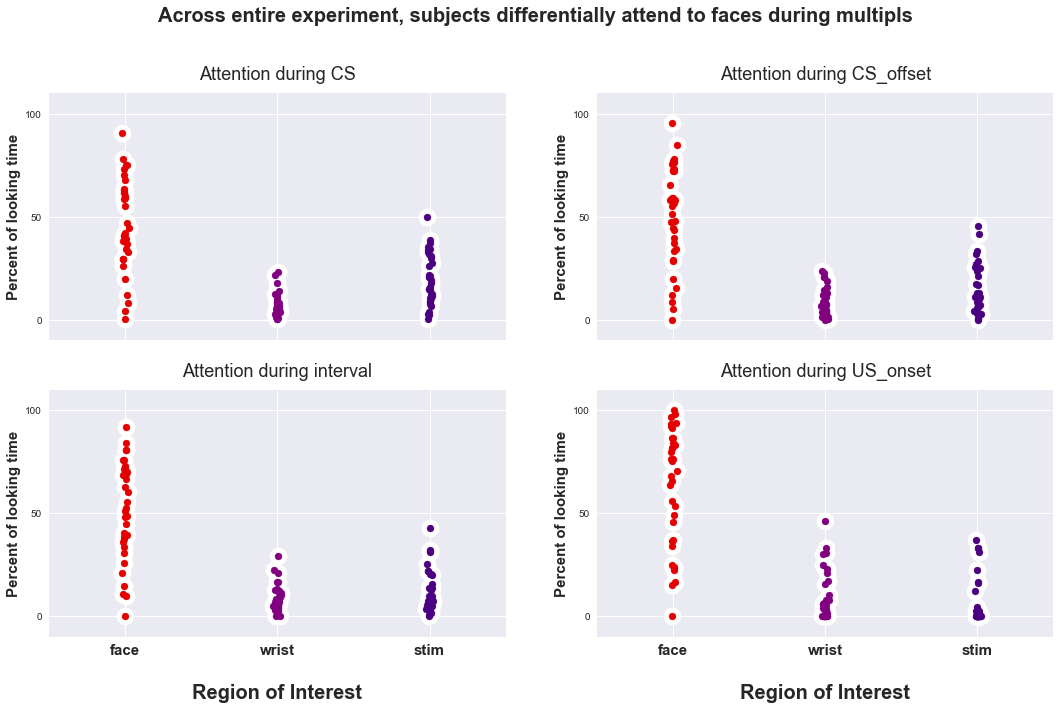

In [34]:
figure(figsize=[18,10])
colors = ['indigo',  'purple', 'xkcd:red']
intervals = gaze_data[gaze_subjects[0]].keys() 
AOIs = main['CS'].keys() 

ount = 1

for i_interval, i_count in zip(intervals, range(len(intervals))):
    
    place_holder = np.ones(len(main[i_interval][AOIs[0]]))
    
    subplot(2,2,i_count+1);                          
    for i_area, j_count in zip(AOIs, range(len(AOIs))): 
        jitter = np.random.randn(len(place_holder))/100
        scatter(place_holder-j_count+jitter, main[i_interval][i_area], s=300, alpha=1, color = 'white') 
        scatter(place_holder-j_count+jitter, main[i_interval][i_area], alpha=1, color = colors[j_count]) 
    
    p_wrist = stats.ttest_ind( main[i_interval]['face'], main['CS']['wrist'], nan_policy='omit')[1] 
    p_stim = stats.ttest_ind( main[i_interval]['face'], main['CS']['stim'], nan_policy='omit')[1] 
    xlim(-1.5,1.5) ; ylim(-10,110)
    yticks([0,50,100]); 
    if i_count > 1: 
        xlabel('\nRegion of Interest', fontsize=20, fontweight='bold')
        xticks([1, 0, -1], [AOIs[0], AOIs[1], AOIs[2]],  fontsize=15, fontweight='bold')
    else: 
        xticks([1,0,-1], '')
    title('Attention during %s' %(i_interval), 
          fontsize=18, y=1.03)
    #if (i_count+1)%2: 
    ylabel('Percent of looking time', fontsize=15, fontweight='bold')   
         
t = suptitle('Across entire experiment, subjects differentially attend to faces during multipls', 
        fontweight='bold', fontsize=20, y=1.00)
savefig('%s/gaze_patterns_whole_experiment.png'%results_folder, bbox_inches='tight', bbox_extra_artists=[t])

In [35]:
# generate composite attention measure

attention = {i_key:[] for i_key in main.keys()}

for i_subject in range(len(gaze_subjects)):
    for timeframe in main.keys(): 
        tmp_attention = []
        for AOI in main[timeframe].keys(): 
            tmp_attention.append(main[timeframe][AOI][i_subject])

        attention[timeframe].append(sum(np.array(tmp_attention)))

        
for i_key in main.keys(): 
    main[i_key]['sum'] = attention[i_key]

In [36]:
# generate data frame for gaze data

gaze_frame = pandas.DataFrame() 

for time_frame in main.keys(): 
    for AOI in main[time_frame].keys(): 
        gaze_frame['%s_%s'%(time_frame, AOI)] = main[time_frame][AOI]

gaze_frame.index = map(int, gaze_subjects)


In [37]:

data_frame = gaze_frame.join(SCR)


In [38]:

with open(behavioral_data) as f:  # Python 3: open(..., 'rb')
    all_behavioral, session_data, trait_data = pickle.load(f)
    
session_data.index = map(int, session_data['subject_id'].values)
trait_data.index = map(int, session_data['subject_id'].values)


In [39]:
data_frame = data_frame.join(session_data)
data_frame = data_frame.join(trait_data)

In [40]:
behave = data_frame
behave = behave.drop(40) # not a naive subject
behave = behave.drop(42) # tyler fucked up protocol

In [41]:
behave.voltage.values[behave.voltage.values>10] = (behave.voltage.values[behave.voltage.values>10])/10

In [42]:
def show_relationship(data_frame, x_var, y_var, color='indigo', alpha=.8, line_alpha=.1): 
    
    sns.set_style("dark", {'axes.grid' : False}, )

    X_ = data_frame[x_var].values
    y_ = data_frame[y_var].values
    
    keepers = np.array(X_ == X_) & np.array(y_ == y_)
    y = y_[keepers]
    X = X_[keepers]

    slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)
    xx = np.arange(min(X), max(X))
    yy = slope * xx + intercept
    sns.despine()
    # Print out the statistics
    
    if p_value < .05: plot(xx, yy, linewidth=14,alpha=line_alpha, color=color)
    scatter(X, y, s=600, color='white', alpha=1)
    scatter(X, y, s=150, color=color, alpha=alpha)
    
    yticks([]); xticks([])
    xlabel(x_var, fontsize=15)
    ylabel(y_var, fontsize=15)

    title('Relating %s and %s (p < %.3f)\n'%(x_var, y_var, p_value), fontsize=15, fontweight='bold')

In [43]:
def show_gaze_relationships(_11, _12, _21, _22, _31, _32, _title_, _color_, _data_, _file_title): 
    figure(figsize=[20,5])
    subplot(1,3,1)
    show_relationship(behave, _11, _12, color=_color_)
    subplot(1,3,2)
    show_relationship(behave, _21, _22, color=_color_)
    subplot(1,3,3)
    show_relationship(behave, _31, _32, color=_color_)
    suptitle(_title_, y=1.1, fontsize=25, fontweight='bold');
    savefig('%s/%s.png'%(results_folder, _file_title))

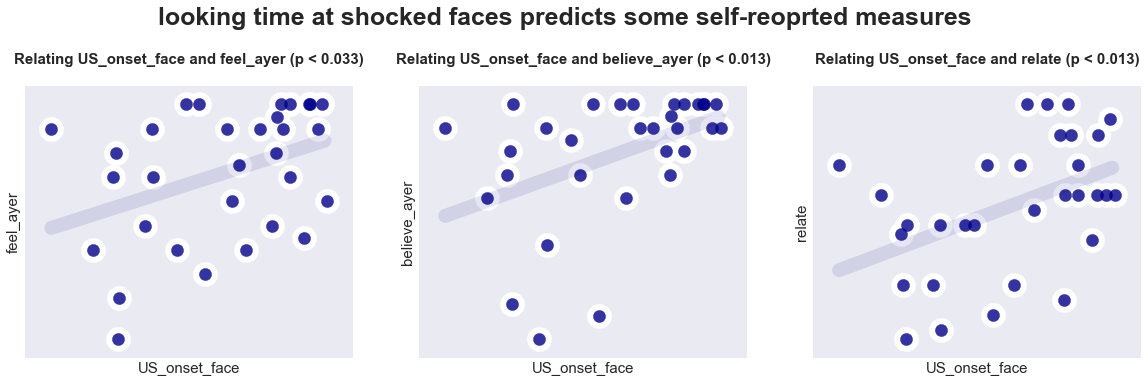

In [44]:
show_gaze_relationships('US_onset_face', 'feel_ayer',
                        'US_onset_face', 'believe_ayer', 
                        'US_onset_face', 'relate', 
                        'looking time at shocked faces predicts some self-reoprted measures', 
                        'darkblue', behave, 'faces_and_self_report') 

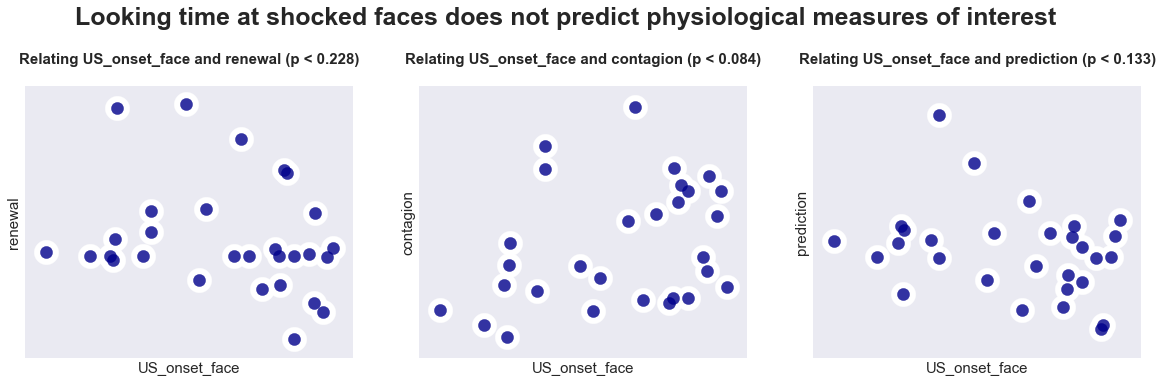

In [45]:
show_gaze_relationships('US_onset_face', 'renewal',
                        'US_onset_face', 'contagion', 
                        'US_onset_face', 'prediction', 
                        'Looking time at shocked faces does not predict physiological measures of interest', 
                        'darkblue', behave, 'faces_and_physio') 

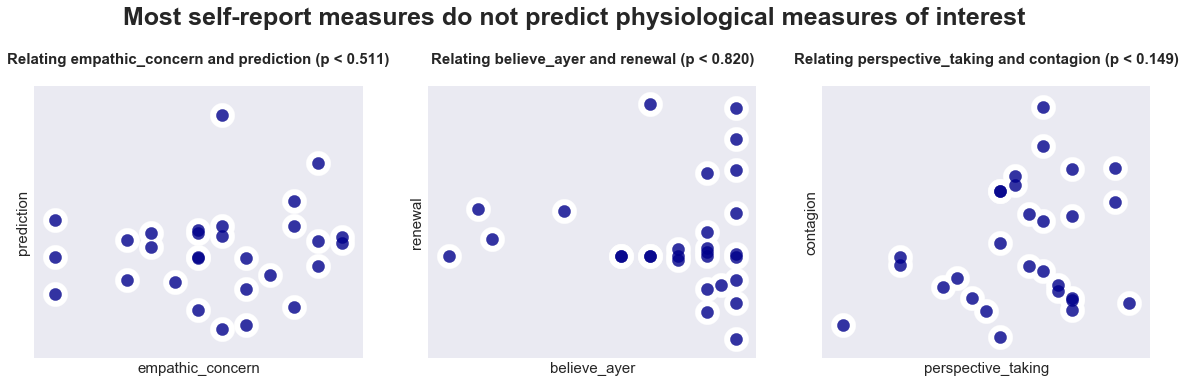

In [46]:
show_gaze_relationships('empathic_concern', 'prediction',
                        'believe_ayer', 'renewal', 
                        'perspective_taking', 'contagion', 
                        'Most self-report measures do not predict physiological measures of interest', 
                        'darkblue', behave, 'self_report_not_renewal') 

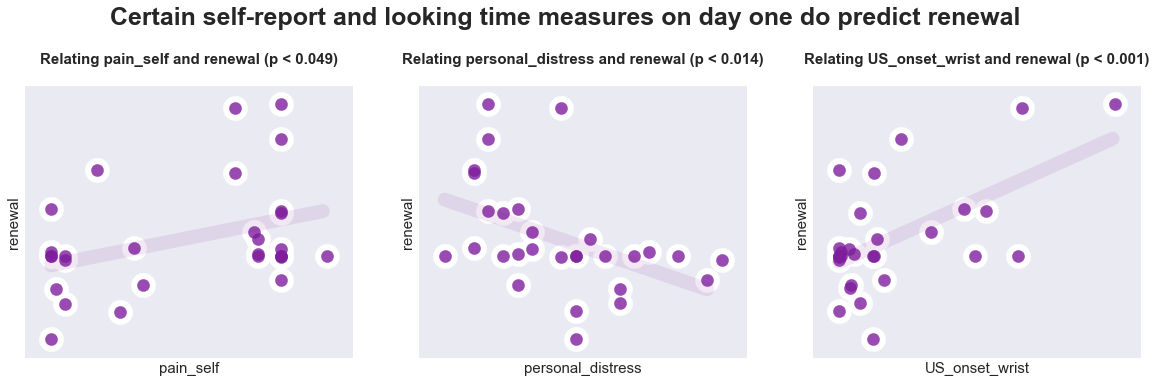

In [47]:
show_gaze_relationships('pain_self', 'renewal',
                        'personal_distress', 'renewal', 
                        'US_onset_wrist', 'renewal', 
                        'Certain self-report and looking time measures on day one do predict renewal', 
                        'xkcd:purple', behave, 'self_report_renewal') 

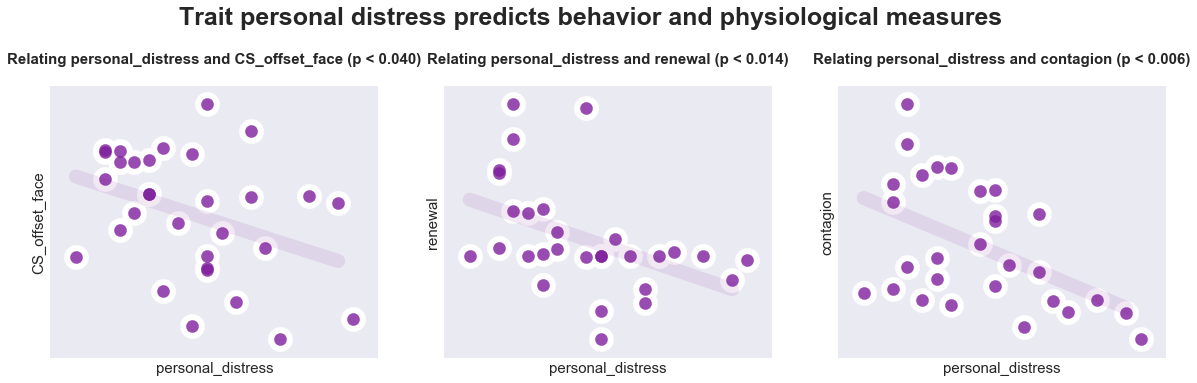

In [66]:
show_gaze_relationships('personal_distress', 'CS_offset_face',
                        'personal_distress', 'renewal', 
                        'personal_distress', 'contagion', 
                        'Trait personal distress predicts behavior and physiological measures', 
                        'xkcd:purple', behave, 'presonal_distress_physio') 

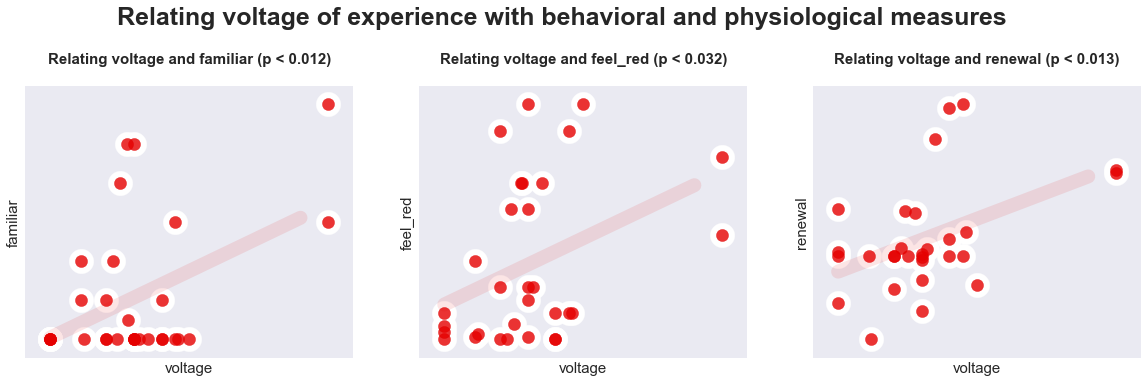

In [58]:
show_gaze_relationships('voltage', 'familiar',
                        'voltage', 'feel_red', 
                        'voltage', 'renewal', 
                        'Relating voltage of experience with behavioral and physiological measures ', 
                        'xkcd:red', behave, 'voltage') 

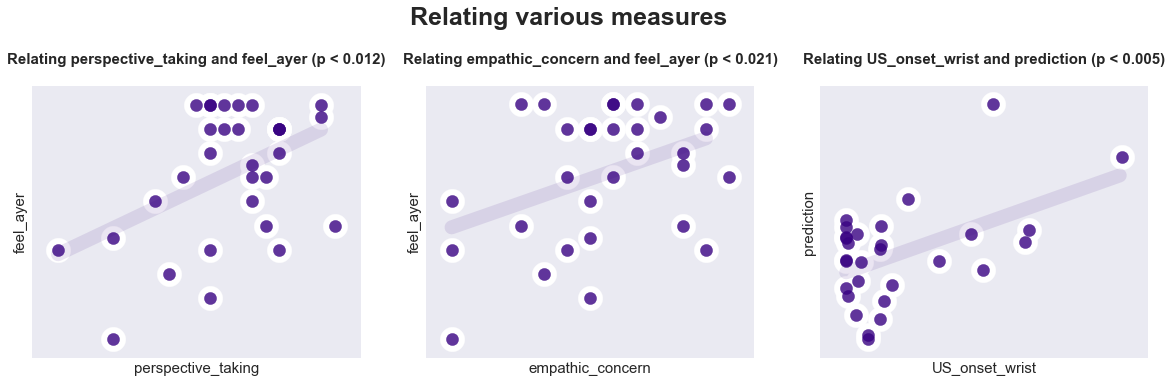

In [72]:
show_gaze_relationships('perspective_taking', 'feel_ayer', 
                        'empathic_concern', 'feel_ayer', 
                        'US_onset_wrist', 'prediction', 
                        'Relating various measures ', 
                        'xkcd:indigo', behave, 'various') 

In [50]:
def show_vector_of_correlations(corr_mat, _type_, ): 
    index = np.nonzero([_type_== key for key in corr_mat.keys()])[0][0]
    sns.set_style("dark", {'axes.grid' : False})
    imshow(corr_mat[[index]], cmap='bwr', vmax=1, vmin=-1)
    yticks(range(len(corr_mat.keys())),corr_mat.keys(), fontsize=15); 
    title('\n%s\n'%_type_, fontsize=15, fontweight='bold'); 
    xticks([]); 

In [51]:
complete_correlation_matrix = behave.corr()

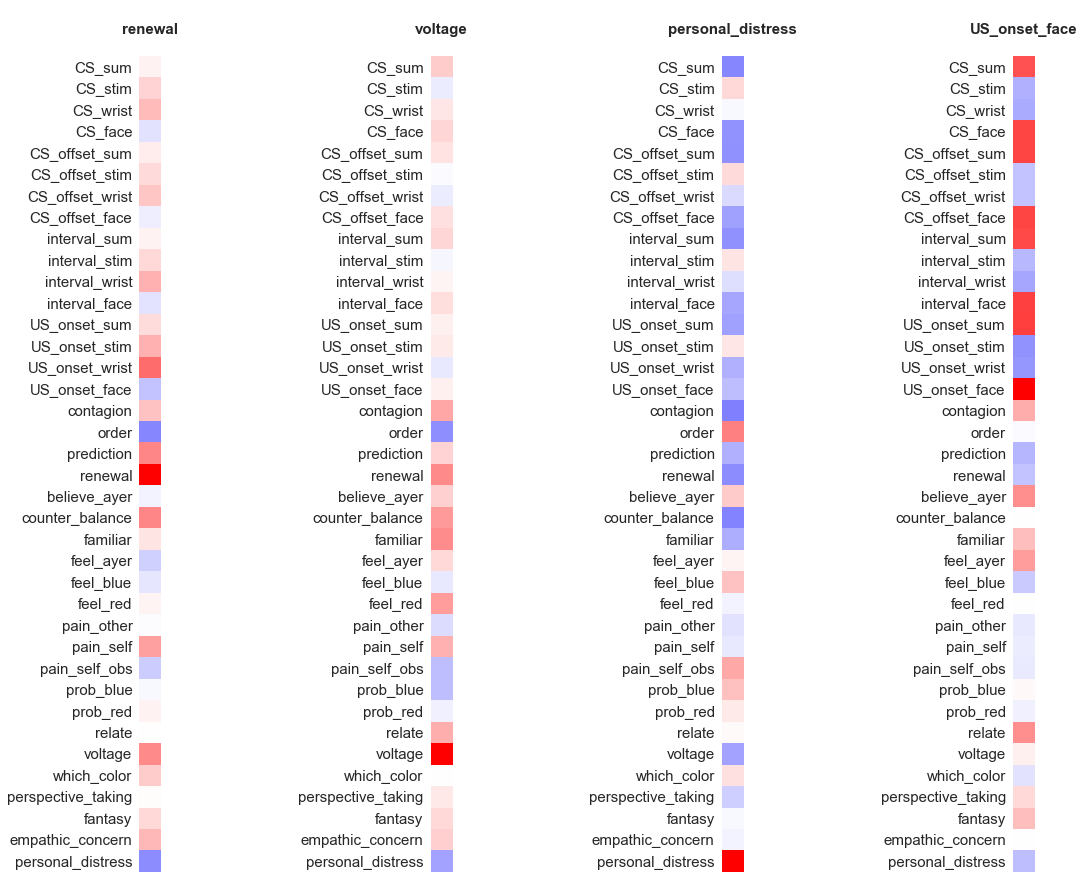

In [52]:
figure(figsize=[20,15])

subplot(1,4,1)
show_vector_of_correlations(complete_correlation_matrix, 'renewal')
subplot(1,4,2)
show_vector_of_correlations(complete_correlation_matrix, 'voltage')
subplot(1,4,3)
show_vector_of_correlations(complete_correlation_matrix, 'personal_distress')
subplot(1,4,4)
show_vector_of_correlations(complete_correlation_matrix, 'US_onset_face')

In [53]:
def show_complte_correlation_matrix(): 

    sns.set_style("dark", {'axes.grid' : False})
    figure(figsize=[10,10])
    complete_names = complete_correlation_matrix.columns
    xs = np.arange(0,len(complete_names),1)
    ys = np.arange(0,len(complete_names),1)
    imshow(complete_correlation_matrix, cmap='bwr', vmin=-.8, vmax=.8)
    xticks(xs, complete_names[xs], rotation=90, fontsize=15)
    yticks(ys, complete_names[ys], fontsize=15);

In [54]:
# show_relationship(behave, 'perspective_taking', 'prob_red')

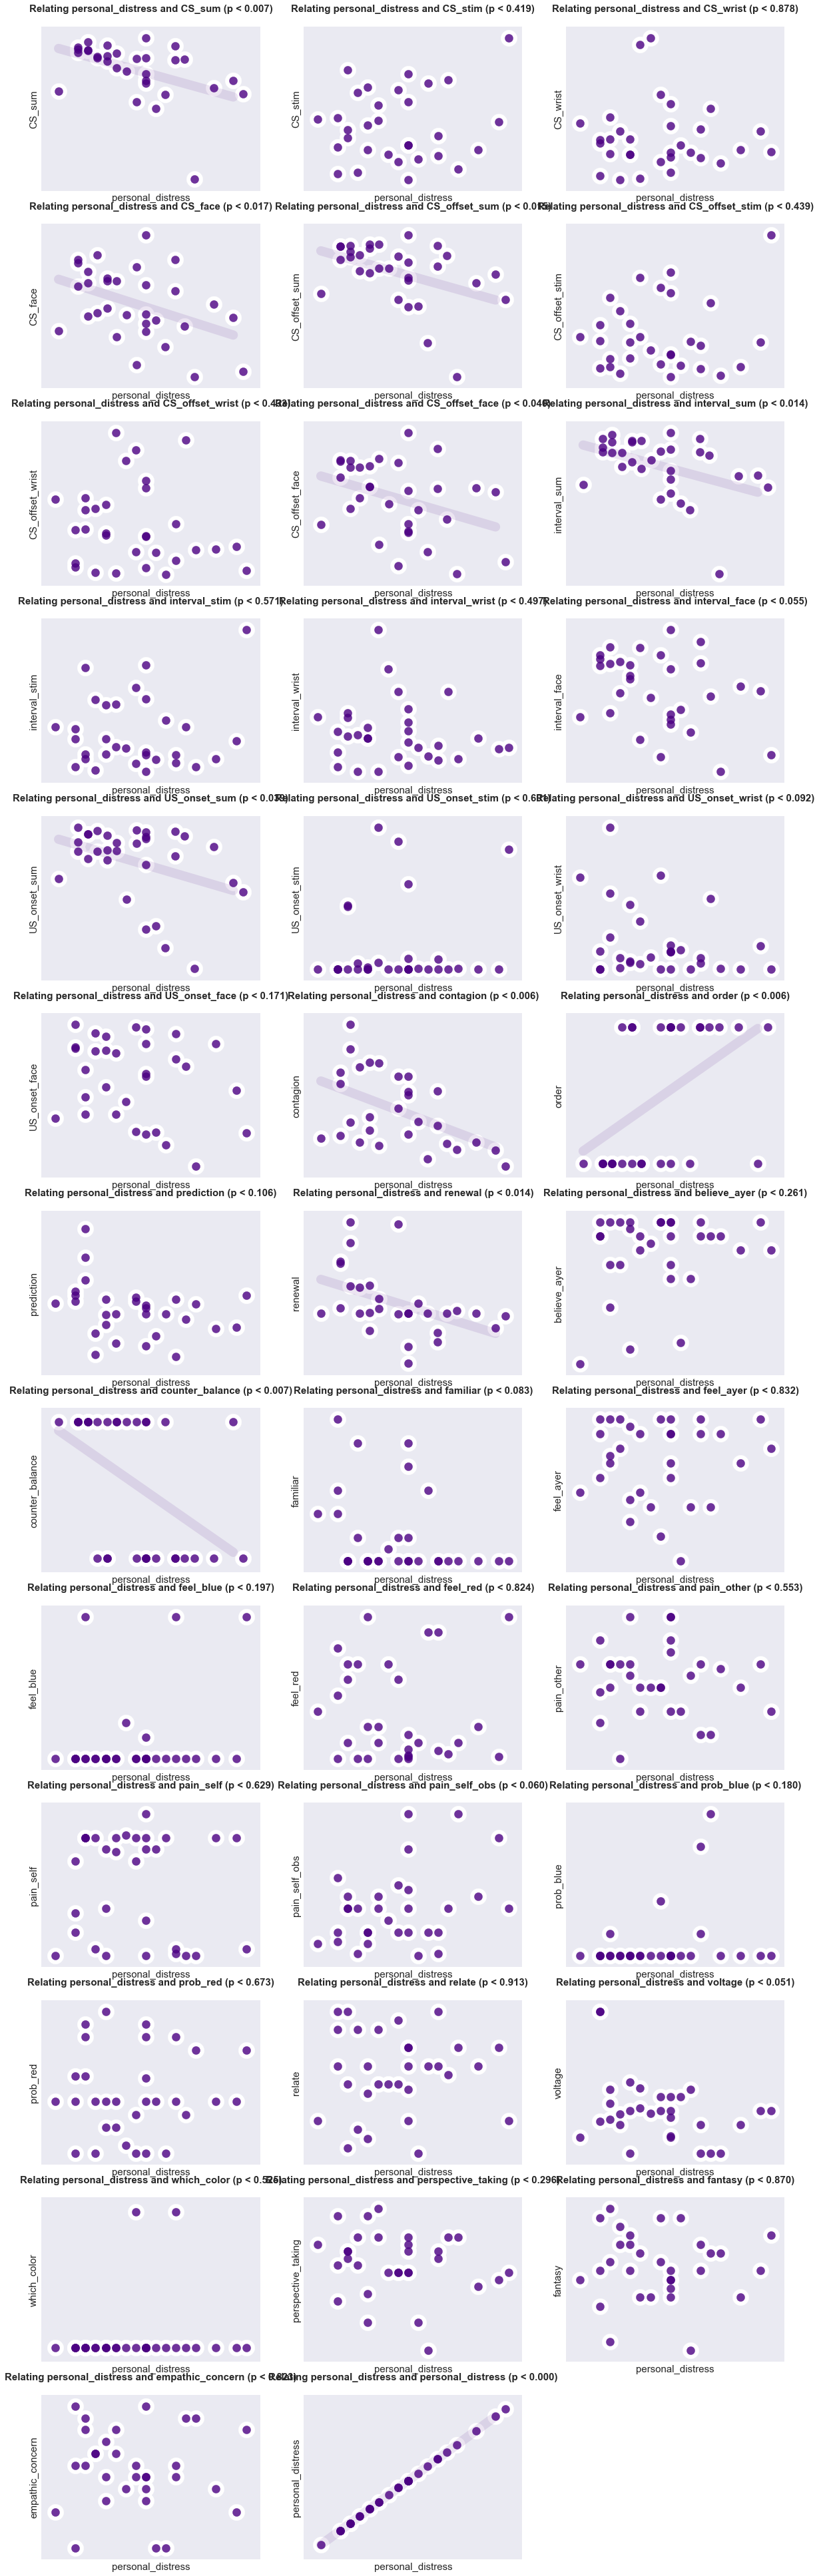

In [64]:
figure(figsize=[20,60+10])
avoid = ['color', 'subject_id', 'subject names']
count = 1
for ii in behave.keys(): 
    if ii not in avoid: 
        subplot(13,3,count) ; count = count + 1 
        show_relationship(behave, 'personal_distress', ii)